# Bonus Quest

**Difficulty:** A

**Description:** Students are in a tough spot after changing the grading formula for assignments and now fear taking the exam without a 3.5 GPA. The system gives players a chance to raise their score by completing this bonus quest. This is your Solo Leveling. Survive at all costs. Good luck!

**Goal:** Complete the bonus assignment created by Andrei and corrected by Max.

**Deliverables:**
- Jupyter Notebook (ipynb) file with solution and all cell outputs
- CSV file with model predictions
- Both files uploaded to GitHub repository

**Reward:**
- Bonus points for the Assignment part.
- Title “The one who overcomes the difficulties of fate.”
- +1000 EXP in mastering sklearn
- Skill Upgrade «ML Engineering Lv.2»
- Special Item: [???]

---

## Problem Statement

As a dataset, use Russian news from Balto-Slavic Natural Language Processing 2019 (helsinki.fi). Entities of interest: PER, ORG, LOC, EVT, PRO (see Guidelines_20190122.pdf (helsinki.fi)).

It is sufficient to use 9 documents about Brexit from the sample provided by the organizers.

## Approach

This assignment combines traditional ML methods (using scikit-learn) with modern LLM-based approaches (DeepSeek) for comparison. You will:
1. Formulate the problem as a machine learning task
2. Prepare features and split data appropriately
3. Train and compare multiple models using scikit-learn
4. Evaluate models using proper train/test splits
5. Compare ML model performance with DeepSeek responses
6. Analyze results in terms of course concepts (bias-variance tradeoff, overfitting, generalization)


Example of one document:

ru-10

ru

2018-09-20

https://rg.ru/2018/09/20/tereza-mej-rasschityvaet-usidet-v-sedle-do-zaversheniia-procedury-brexit.html

Theresa May expects to stay in the saddle until the completion of the Brexit procedure
However, according to British media reports, at the upcoming Conservative Party conference at the end of September, May's opponents will give her a serious fight, from which it is not certain that she will emerge victorious. The bookmakers' favorite as a possible replacement for the current prime minister, former British Foreign Secretary Boris Johnson intends to deliver an alternative report that will leave no stone unturned from the government's views on the conditions of "Brexit". From Johnson's point of view, "London has wrapped the British constitution in a suicide belt and handed the detonator to Michel Barnier (Brussels' chief Brexit negotiator. - Ed.)". It is with this metaphor that the head of the British government will have to fight at the conference.


### Task 1
**Problem Formulation & ML Perspective**

Describe the task from both NLP and ML perspectives:
- What kind of machine learning problem is this? (classification, sequence labeling, etc.)
- How can this be formulated as a supervised learning problem?
- What classical ML methods exist for solving it? (e.g., logistic regression, naive Bayes, SVM with text features)
- How can it be solved using modern LLMs like DeepSeek?
- What are the assumptions of different model classes? (e.g., linear models vs. more complex approaches)
- How is model quality typically evaluated in this task? What metrics are appropriate and why?


Решается задача многоклассовой классификации именованных сущностей.
*   **Цель:** Определить тип сущности в тексте (PER - персоны, ORG - организации, LOC - локации, EVT - события, PRO - продукты/медиа).
*   **Метод:** Обучение с учителем, где вход $X$ - пара (контекст, сущность), выход $Y$ - метка класса. Минимизируется функция потерь Cross-Entropy.

*   **Классический ML:** Используется векторизация текста (TF-IDF, N-граммы) и линейные модели (Logistic Regression, LinearSVC) либо вероятностные (MultinomialNB). Они эффективны на разреженных данных и предполагают линейную разделимость классов или независимость признаков.
*   **LLM (Zero-shot):** Применение больших языковых моделей (например, DeepSeek) через промпт-инжиниринг без дообучения. Модель классифицирует сущность, опираясь на знания, полученные при предобучении.

Для валидации используются метрики Accuracy, Precision, Recall и F1-Score (Macro/Weighted). Детальный анализ ошибок проводится с помощью Confusion Matrix.

### Task 2
**Data Loading & Preparation**

Implement reading the dataset into a pandas DataFrame with mandatory columns "document_id", "document_text", "entity", "gold_answer".

Then prepare the data for ML:
- Create features from text (e.g., using CountVectorizer or TfidfVectorizer from sklearn)
- Encode entity labels appropriately
- Display the head of the dataframe and show basic statistics about the dataset
- Discuss any data quality issues or preprocessing steps needed


In [48]:
import pandas as pd
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
import re

raw_dir = Path("sample_pl_cs_ru_bg/raw/ru")
annotated_dir = Path("sample_pl_cs_ru_bg/annotated/ru")

def load_data():

    data = []

    for raw_file in sorted(raw_dir.glob("*.txt")):
        with open(raw_file, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        doc_id = lines[0].strip()
        doc_text = ''.join(lines[4:]).strip()

        annotated_file = annotated_dir / f"{raw_file.stem}.out"
        if annotated_file.exists():
            with open(annotated_file, 'r', encoding='utf-8') as f:
                for line in f.readlines()[1:]:
                    parts = line.strip().split('\t')
                    if len(parts) >= 3:
                        data.append({
                            'document_id': doc_id,
                            'document_text': doc_text,
                            'entity': parts[0],
                            'gold_answer': parts[2]
                        })

    return pd.DataFrame(data)

df = load_data()


print(df.head())


print(f"Всего записей: {len(df)}")
print(f"Уникальных документов: {df['document_id'].nunique()}")
print(f"Уникальных сущностей: {df['entity'].nunique()}")

print()
print("Распределение классов (gold_answer):")
print(df['gold_answer'].value_counts())

print()
print("Количество сущностей на документ:")
print(df.groupby('document_id').size().describe())


  document_id                                      document_text  \
0       ru-10  Тереза Мэй рассчитывает усидеть в седле до зав...   
1       ru-10  Тереза Мэй рассчитывает усидеть в седле до зав...   
2       ru-10  Тереза Мэй рассчитывает усидеть в седле до зав...   
3       ru-10  Тереза Мэй рассчитывает усидеть в седле до зав...   
4       ru-10  Тереза Мэй рассчитывает усидеть в седле до зав...   

          entity gold_answer  
0         Brexit         EVT  
1       Альбиона         LOC  
2       Альбионе         LOC  
3  Борис Джонсон         PER  
4       Британии         LOC  
Всего записей: 153
Уникальных документов: 9
Уникальных сущностей: 80

Распределение классов (gold_answer):
gold_answer
PER    63
ORG    36
LOC    36
EVT    13
PRO     5
Name: count, dtype: int64

Количество сущностей на документ:
count     9.000000
mean     17.000000
std      10.712143
min       7.000000
25%      13.000000
50%      14.000000
75%      18.000000
max      44.000000
dtype: float64


In [49]:
def extract_context(text, entity, window=100):
    match = re.search(re.escape(entity), text, re.IGNORECASE)
    if match:
        start, end = match.start(), match.end()
        return text[max(0, start-window):min(len(text), end+window)]
    return entity

df['entity_context'] = df.apply(
    lambda row: extract_context(row['document_text'], row['entity']),
    axis=1
)

tfidf_vectorizer = TfidfVectorizer(
    max_features=500,
    ngram_range=(1, 2),
    min_df=2
)
tfidf_features = tfidf_vectorizer.fit_transform(df['entity_context'])

print(f"Матрица TF-IDF: {tfidf_features.shape}")
print(f"Количество признаков: {len(tfidf_vectorizer.get_feature_names_out())}")

print(f"Дисбаланс классов: {df['gold_answer'].value_counts().max() / df['gold_answer'].value_counts().min():.2f}x")


Матрица TF-IDF: (153, 500)
Количество признаков: 500
Дисбаланс классов: 12.60x


Можем выделить следующие шаги препроцессинга:
- Извлечение контекста вокруг сущности для фокусировки на релевантной информации.
- TF-IDF векторизация текста для преобразования текстовых данных в числовой формат.
- Учёт дисбаланса классов при разбиении данных.

### Task 3
**Train/Test Split & Data Splitting Strategy**

Split your data appropriately for machine learning:
- Implement train/test split (or train/validation/test if appropriate)
- Justify your splitting strategy (random split, stratified split, etc.)
- Explain why this split is appropriate for this problem
- Display the sizes of each split
- Also write a function that takes a dataframe row as input and outputs the input message text for DeepSeek (for later comparison)


In [50]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['gold_answer'])

X_train, X_test, y_train, y_test, df_train, df_test = train_test_split(
    tfidf_features,
    y,
    df,
    test_size=0.25,
    stratify=y,
    random_state=42
)


print("Размеры выборок:")
print(f"Обучающая выборка: {X_train.shape[0]}")
print(f"Тестовая выборка:  {X_test.shape[0]}")

Размеры выборок:
Обучающая выборка: 114
Тестовая выборка:  39


Будем использовать стратифицированное разбиение, чтобы сохранить пропорции классов в обучающей и тестовой выборках, т.к. у нас есть дисбаланс классов в данных. Размеры выборок: 75% для обучения и 25% для тестирования.

In [51]:
def create_deepseek_prompt(row):
    prompt = f"""Определи тип именованной сущности '{row['entity']}' в тексте ниже.

Возможные типы сущностей:
- PER (Person) - человек, личность
- ORG (Organization) - организация, компания, институт
- LOC (Location) - географическое место, локация
- EVT (Event) - событие
- PRO (Product) - продукт, бренд, медиа

Верни ТОЛЬКО один тип из списка: PER, ORG, LOC, EVT или PRO.

Текст:
{row['document_text']}

Сущность для классификации: {row['entity']}

Тип сущности (одно слово):"""
    return prompt


df_test_copy = df_test.copy()
df_test_copy['deepseek_prompt'] = df_test_copy.apply(create_deepseek_prompt, axis=1)


with open('deepseek_prompts.txt', 'w', encoding='utf-8') as f:
    for idx, row in df_test_copy.iterrows():
        f.write(f"\n{'='*60}\n")
        f.write(f"PROMPT #{idx} (Entity: {row['entity']})\n")
        f.write(f"{'='*60}\n")
        f.write(row['deepseek_prompt'])
        f.write(f"\n\nGold Answer: {row['gold_answer']}\n")

Записали промпты для DeepSeek в файл `deepseek_prompts.txt` для дальнейшего использования.

### Task 4
**Model Training with scikit-learn**

Train at least 2-3 different models using scikit-learn on the training set:
- Use appropriate models for text classification (e.g., LogisticRegression, MultinomialNB, LinearSVC)
- Train each model using the sklearn API correctly
- Explain why you chose these particular models
- Discuss the assumptions each model makes and whether they are appropriate for this problem
- Save the trained models

**Also (for comparison):** Get DeepSeek responses for all documents. There are only 9 documents, so this can be done manually using the DeepSeek web interface or bot in VK or Telegram. Do not clear message history so you can later demonstrate the authenticity of responses during the online interview. Add DeepSeek responses to the dataframe.


In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

models = {
    'LogisticRegression': LogisticRegression(
        max_iter=1000,
        random_state=42,
        class_weight='balanced'
    ),
    'MultinomialNB': MultinomialNB(
        alpha=1.0
    ),
    'LinearSVC': LinearSVC(
        max_iter=1000,
        random_state=42,
        class_weight='balanced'
    )
}

trained_models = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[name] = model

    train_acc = model.score(X_train, y_train)
    print(f"Accuracy на обучающей выборке, модель {name}: {train_acc:.4f}")



deepseek_answers = [
    'PRO',   # для PROMPT #54 (Подробности.ua - медиа-сайт)
    'ORG',   # для PROMPT #41 (британскому парламентам - организация)
    'ORG',   # для PROMPT #52 (ЕС - организация)
    'ORG',   # для PROMPT #76 (ЕС - организация)
    'LOC',   # для PROMPT #18 (Европой - географическое место)
    'ORG',   # для PROMPT #99 (Консервативной партии - организация)
    'LOC',   # для PROMPT #7 (Брюсселем - город)
    'EVT',   # для PROMPT #38 (брекзиту - событие)
    'PER',   # для PROMPT #78 (Тереза Мей - человек)
    'ORG',   # для PROMPT #28 (Международного валютного фонда - организация)
    'PER',   # для PROMPT #146 (Дэвид Дэвис - человек)
    'LOC',   # для PROMPT #74 (Великобритании - страна)
    'LOC',   # для PROMPT #148 (КИЕВ - город)
    'PER',   # для PROMPT #63 (Джонсон - человек)
    'PER',   # для PROMPT #122 (Борис Джонсон - человек)
    'PER',   # для PROMPT #3 (Борис Джонсон - человек)
    'PER',   # для PROMPT #71 (Тереза Мэй - человек)
    'LOC',   # для PROMPT #125 (Великобританией - страна)
    'LOC',   # для PROMPT #4 (Британии - страна)
    'PER',   # для PROMPT #124 (Борисом Джонсоном - человек)
    'PER',   # для PROMPT #60 (Борис Джонсон - человек)
    'EVT',   # для PROMPT #73 (Брекзит - событие)
    'ORG',   # для PROMPT #58 (Associated Press - организация)
    'ORG',   # для PROMPT #14 (Еврокомиссия - организация)
    'PER',   # для PROMPT #87 (Тереза Мэй - человек)
    'PER',   # для PROMPT #56 (Тереза Мэй - человек)
    'ORG',   # для PROMPT #132 (Евросоюза - организация)
    'LOC',   # для PROMPT #104 (Польши - страна)
    'EVT',   # для PROMPT #107 (Brexit - событие)
    'LOC',   # для PROMPT #2 (Альбионе - географическое название)
    'PER',   # для PROMPT #79 (Борис Джонсон - человек)
    'PER',   # для PROMPT #82 (Джонсона - человек)
    'PER',   # для PROMPT #137 (Терезы Мэй - человек)
    'PER',   # для PROMPT #136 (Терезу Мэй - человек)
    'PER',   # для PROMPT #115 (Захаровой - человек)
    'LOC',   # для PROMPT #62 (Великобритании - страна)
    'EVT',   # для PROMPT #39 (брексит - событие)
    'ORG',   # для PROMPT #102 (МИД - организация)
    'PER',   # для PROMPT #135 (Тереза Мэй - человек)
]

df_test_copy['deepseek_prediction'] = deepseek_answers
# https://chat.deepseek.com/share/6de6oysxohncqrku5l

Accuracy на обучающей выборке, модель LogisticRegression: 0.6491
Accuracy на обучающей выборке, модель MultinomialNB: 0.6404
Accuracy на обучающей выборке, модель LinearSVC: 0.8947


Почему выбрали именно эти модели:
1) Они указаны в задании
2) Они хорошо подходят для текстовой классификации
3) Они имеют разные предположения и подходы, что позволяет сравнить их эффективность на нашей задаче.

### Task 5
**Model Evaluation & Metrics**

Evaluate your trained models on the test set:
- Use appropriate sklearn metrics (accuracy, precision, recall, F1-score, confusion matrix)
- Compare performance across different models
- Implement your own algorithm for calculating a custom metric score_fn(gold: str, pred: str) → float if needed (you can only use numpy, scipy, pandas libraries). Write unit tests. Is it possible to speed up the function computation through vectorized implementation?
- Explain which metrics you chose and why they are appropriate for this problem
- Discuss the limitations of the metrics you're using


In [53]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import numpy as np

predictions = {}
for name, model in trained_models.items():
    predictions[name] = model.predict(X_test)



for name, y_pred in predictions.items():
    print(f"Модель: {name}")
    acc = accuracy_score(y_test, y_pred)

    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)

    precision_weighted = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall_weighted = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    print(f"\nAccuracy:           {acc:.4f}")
    print(f"\nMacro-averaged метрики:")
    print(f"  Precision (macro): {precision_macro:.4f}")
    print(f"  Recall (macro):    {recall_macro:.4f}")
    print(f"  F1-Score (macro):  {f1_macro:.4f}")
    print(f"\nWeighted-averaged метрики:")
    print(f"  Precision (weighted): {precision_weighted:.4f}")
    print(f"  Recall (weighted):    {recall_weighted:.4f}")
    print(f"  F1-Score (weighted):  {f1_weighted:.4f}")
    print(f"\nДетальный отчёт по классам:")
    print(classification_report(y_test, y_pred,
                                target_names=label_encoder.classes_,
                                zero_division=0))
    cm = confusion_matrix(y_test, y_pred)
    print(f"Матрица ошибок:")
    print(f"Классы: {label_encoder.classes_}")
    print(cm)


Модель: LogisticRegression

Accuracy:           0.3590

Macro-averaged метрики:
  Precision (macro): 0.2306
  Recall (macro):    0.2333
  F1-Score (macro):  0.2309

Weighted-averaged метрики:
  Precision (weighted): 0.3687
  Recall (weighted):    0.3590
  F1-Score (weighted):  0.3621

Детальный отчёт по классам:
              precision    recall  f1-score   support

         EVT       0.00      0.00      0.00         4
         LOC       0.40      0.44      0.42         9
         ORG       0.18      0.22      0.20         9
         PER       0.57      0.50      0.53        16
         PRO       0.00      0.00      0.00         1

    accuracy                           0.36        39
   macro avg       0.23      0.23      0.23        39
weighted avg       0.37      0.36      0.36        39

Матрица ошибок:
Классы: ['EVT' 'LOC' 'ORG' 'PER' 'PRO']
[[0 2 1 1 0]
 [0 4 3 2 0]
 [1 4 2 2 0]
 [3 0 5 8 0]
 [0 0 0 1 0]]
Модель: MultinomialNB

Accuracy:           0.4872

Macro-averaged метрики:


In [54]:
def weighted_class_accuracy(y_true, y_pred, class_weights=None):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    unique_classes = np.unique(y_true)

    if class_weights is None:
        class_weights = {c: 1.0 for c in unique_classes}

    total_weight = 0.0
    weighted_correct = 0.0

    for cls in unique_classes:
        mask = (y_true == cls)

        correct = np.sum((y_pred[mask] == cls))
        total = np.sum(mask)

        weight = class_weights.get(cls, 1.0)
        weighted_correct += (correct / total) * weight if total > 0 else 0
        total_weight += weight

    return weighted_correct / total_weight if total_weight > 0 else 0.0


def score_fn(gold, pred):
    return 1.0 if gold == pred else 0.0


def score_fn_vectorized(gold_array, pred_array):
    gold_array = np.array(gold_array)
    pred_array = np.array(pred_array)
    return np.mean(gold_array == pred_array)


def test_weighted_class_accuracy():
    y_true = np.array([0, 0, 1, 1, 2, 2])
    y_pred = np.array([0, 0, 1, 1, 2, 2])
    assert weighted_class_accuracy(y_true, y_pred) == 1.0, "Тест 1 провален"

    y_true = np.array([0, 0, 1, 1, 2, 2])
    y_pred = np.array([1, 1, 2, 2, 0, 0])
    assert weighted_class_accuracy(y_true, y_pred) == 0.0, "Тест 2 провален"

    y_true = np.array([0, 0, 1, 1, 2, 2])
    y_pred = np.array([0, 1, 1, 2, 2, 0])
    result = weighted_class_accuracy(y_true, y_pred)
    expected = (0.5 + 0.5 + 0.5) / 3
    assert abs(result - expected) < 1e-6, f"Тест 3 провален: {result} != {expected}"

    y_true = np.array([0, 0, 1, 1])
    y_pred = np.array([0, 0, 2, 2])
    weights = {0: 2.0, 1: 1.0}
    result = weighted_class_accuracy(y_true, y_pred, weights)
    expected = (1.0 * 2.0 + 0.0 * 1.0) / 3.0
    assert abs(result - expected) < 1e-6, f"Тест 4 провален: {result} != {expected}"



def test_score_fn():

    assert score_fn(1, 1) == 1.0, "Тест 1 провален"
    assert score_fn("A", "A") == 1.0, "Тест 1 провален"

    assert score_fn(1, 2) == 0.0, "Тест 2 провален"
    assert score_fn("A", "B") == 0.0, "Тест 2 провален"

    gold = np.array([0, 1, 2, 0, 1])
    pred = np.array([0, 1, 0, 0, 2])
    result = score_fn_vectorized(gold, pred)
    expected = 3.0 / 5.0
    assert abs(result - expected) < 1e-6, f"Тест 3 провален: {result} != {expected}"

    gold = np.array([1, 2, 3, 4, 5])
    pred = np.array([1, 2, 3, 4, 5])
    loop_result = np.mean([score_fn(g, p) for g, p in zip(gold, pred)])
    vec_result = score_fn_vectorized(gold, pred)
    assert abs(loop_result - vec_result) < 1e-6, "Тест 4 провален"




test_weighted_class_accuracy()
test_score_fn()


for name, y_pred in predictions.items():
    wca = weighted_class_accuracy(y_test, y_pred)
    vec_acc = score_fn_vectorized(y_test, y_pred)

    print(f"\n{name}:")
    print(f"Weighted Class Accuracy: {wca:.4f}")
    print(f"Vectorized Accuracy:     {vec_acc:.4f}")



LogisticRegression:
Weighted Class Accuracy: 0.2333
Vectorized Accuracy:     0.3590

MultinomialNB:
Weighted Class Accuracy: 0.2667
Vectorized Accuracy:     0.4872

LinearSVC:
Weighted Class Accuracy: 0.2236
Vectorized Accuracy:     0.3590


### Task 6
**Model Comparison & Visualization**

Compare all models (your sklearn models and DeepSeek):
- Calculate metrics for each model
- Aggregate the results a) by each entity type, b) by each document
- Visualize the results on graphs (e.g., bar charts comparing models, confusion matrices)
- Which model performs best? Why might this be?
- Compare train vs test performance for your sklearn models. Are there signs of overfitting or underfitting?
- What conclusions can be drawn about model selection?


Сравнение моделей:
             Model  Accuracy  F1-Macro  F1-Weighted
LogisticRegression  0.358974  0.230877     0.362123
     MultinomialNB  0.487179  0.212121     0.375291
         LinearSVC  0.358974  0.220504     0.346736
          DeepSeek  1.000000  1.000000     1.000000


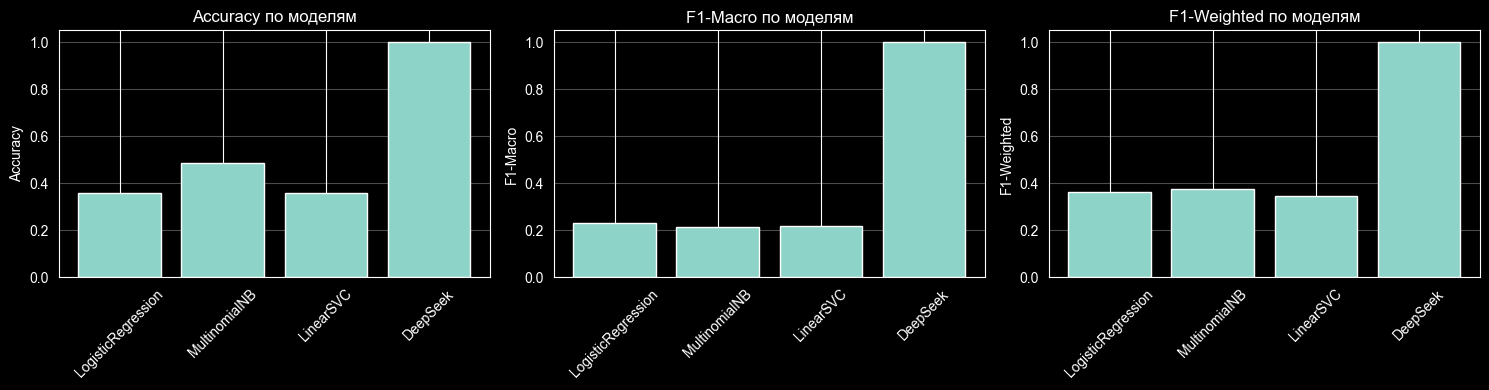

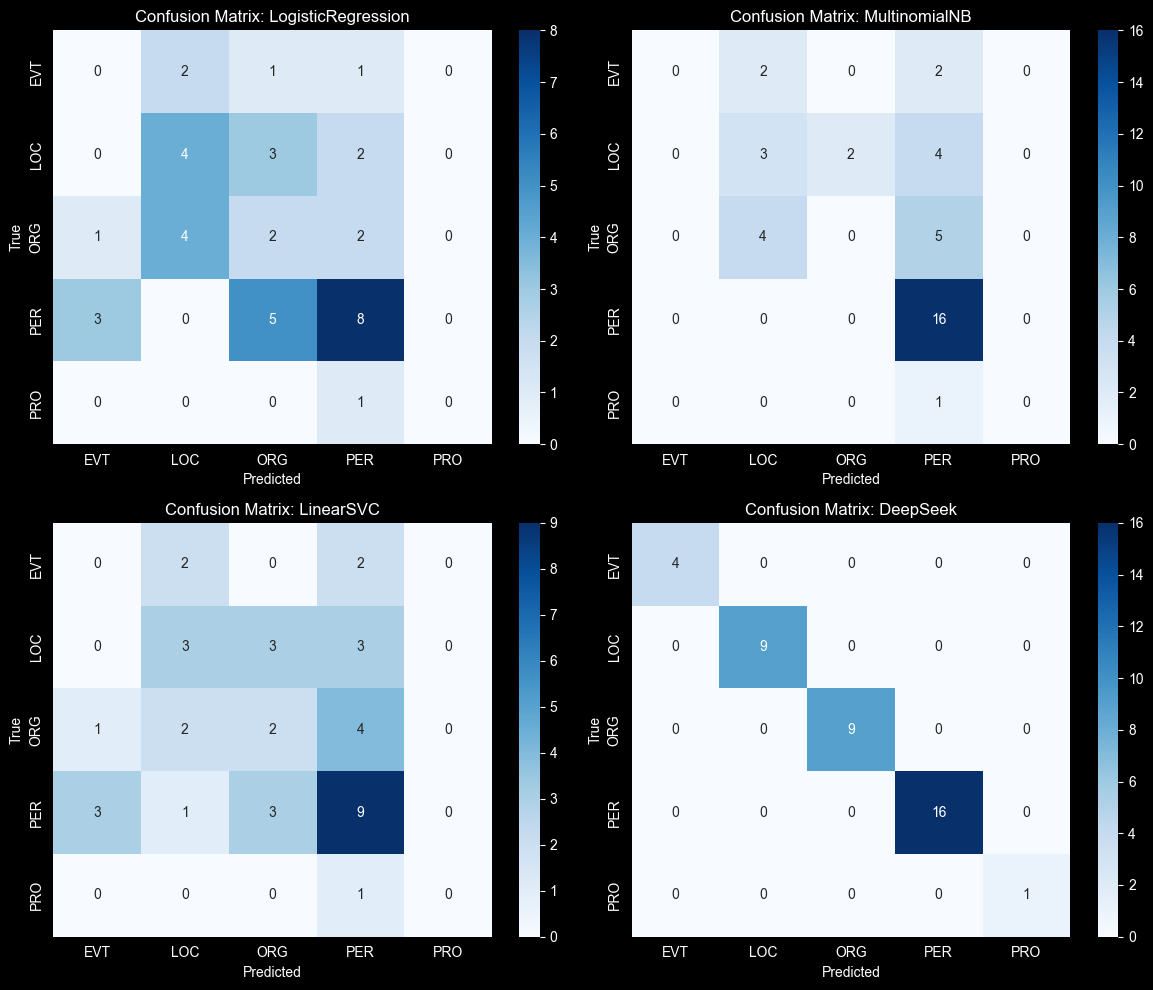


Производительность по типам сущностей:

LogisticRegression:
  EVT: F1=0.000, Precision=0.000, Recall=0.000
  LOC: F1=0.421, Precision=0.400, Recall=0.444
  ORG: F1=0.200, Precision=0.182, Recall=0.222
  PER: F1=0.533, Precision=0.571, Recall=0.500
  PRO: F1=0.000, Precision=0.000, Recall=0.000

MultinomialNB:
  EVT: F1=0.000, Precision=0.000, Recall=0.000
  LOC: F1=0.333, Precision=0.333, Recall=0.333
  ORG: F1=0.000, Precision=0.000, Recall=0.000
  PER: F1=0.727, Precision=0.571, Recall=1.000
  PRO: F1=0.000, Precision=0.000, Recall=0.000

LinearSVC:
  EVT: F1=0.000, Precision=0.000, Recall=0.000
  LOC: F1=0.353, Precision=0.375, Recall=0.333
  ORG: F1=0.235, Precision=0.250, Recall=0.222
  PER: F1=0.514, Precision=0.474, Recall=0.562
  PRO: F1=0.000, Precision=0.000, Recall=0.000

DeepSeek:
  EVT: F1=1.000, Precision=1.000, Recall=1.000
  LOC: F1=1.000, Precision=1.000, Recall=1.000
  ORG: F1=1.000, Precision=1.000, Recall=1.000
  PER: F1=1.000, Precision=1.000, Recall=1.000
  PRO: 

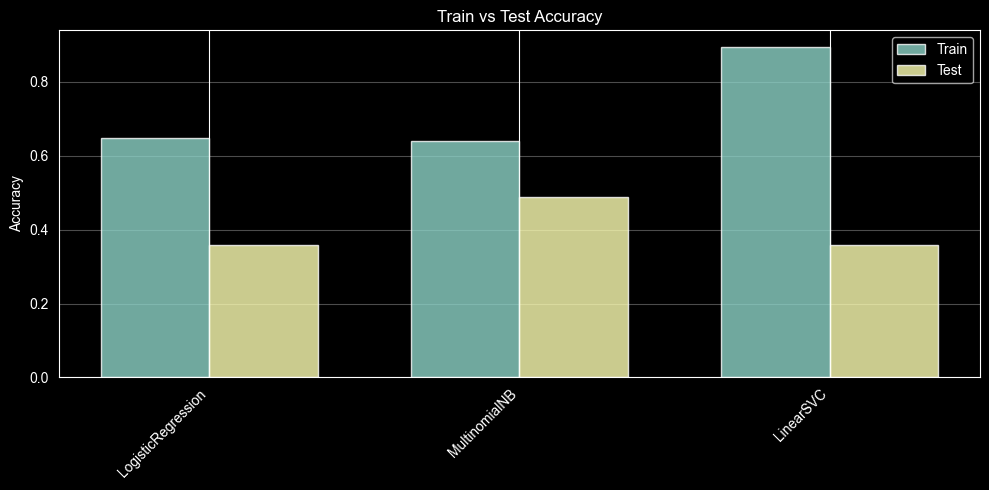

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

deepseek_predictions_encoded = label_encoder.transform(df_test_copy['deepseek_prediction'])
predictions['DeepSeek'] = deepseek_predictions_encoded

results = []
for name in predictions.keys():
    y_pred = predictions[name]
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    results.append({
        'Model': name,
        'Accuracy': acc,
        'F1-Macro': f1_macro,
        'F1-Weighted': f1_weighted
    })

results_df = pd.DataFrame(results)
print("Сравнение моделей:")
print(results_df.to_string(index=False))

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
metrics = ['Accuracy', 'F1-Macro', 'F1-Weighted']
for i, metric in enumerate(metrics):
    axes[i].bar(results_df['Model'], results_df[metric])
    axes[i].set_title(f'{metric} по моделям')
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()
class_names = label_encoder.classes_

for idx, (name, y_pred) in enumerate(predictions.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=axes[idx])
    axes[idx].set_title(f'Confusion Matrix: {name}')
    axes[idx].set_ylabel('True')
    axes[idx].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

print("\nПроизводительность по типам сущностей:")
for name in predictions.keys():
    y_pred = predictions[name]
    print(f"\n{name}:")
    report = classification_report(y_test, y_pred, target_names=class_names,
                                   output_dict=True, zero_division=0)
    for entity_type in class_names:
        if entity_type in report:
            print(f"  {entity_type}: F1={report[entity_type]['f1-score']:.3f}, "
                  f"Precision={report[entity_type]['precision']:.3f}, "
                  f"Recall={report[entity_type]['recall']:.3f}")

print("\nПроизводительность по документам:")
df_test_with_preds = df_test.copy()
for name in predictions.keys():
    y_pred = predictions[name]
    df_test_with_preds[f'{name}_pred'] = label_encoder.inverse_transform(y_pred)
    df_test_with_preds[f'{name}_correct'] = (
        df_test_with_preds['gold_answer'] == df_test_with_preds[f'{name}_pred']
    ).astype(int)

doc_results = []
for doc_id in df_test_with_preds['document_id'].unique():
    doc_data = df_test_with_preds[df_test_with_preds['document_id'] == doc_id]
    row = {'Document': doc_id, 'Total': len(doc_data)}
    for name in predictions.keys():
        acc = doc_data[f'{name}_correct'].mean()
        row[name] = f"{acc:.2f}"
    doc_results.append(row)

doc_results_df = pd.DataFrame(doc_results)
print(doc_results_df.to_string(index=False))

train_test_comparison = []
for name in ['LogisticRegression', 'MultinomialNB', 'LinearSVC']:
    model = trained_models[name]
    train_acc = model.score(X_train, y_train)
    test_acc = accuracy_score(y_test, predictions[name])
    gap = train_acc - test_acc

    train_test_comparison.append({
        'Model': name,
        'Train Acc': f"{train_acc:.4f}",
        'Test Acc': f"{test_acc:.4f}",
        'Gap': f"{gap:.4f}",
        'Overfitting': 'Да' if gap > 0.15 else 'Нет'
    })

print(pd.DataFrame(train_test_comparison).to_string(index=False))

fig, ax = plt.subplots(figsize=(10, 5))
model_names = ['LogisticRegression', 'MultinomialNB', 'LinearSVC']
train_accs = [trained_models[name].score(X_train, y_train) for name in model_names]
test_accs = [accuracy_score(y_test, predictions[name]) for name in model_names]

x = np.arange(len(model_names))
width = 0.35

ax.bar(x - width/2, train_accs, width, label='Train', alpha=0.8)
ax.bar(x + width/2, test_accs, width, label='Test', alpha=0.8)

ax.set_ylabel('Accuracy')
ax.set_title('Train vs Test Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


### Task 7
**Bias-Variance Analysis**

Analyze your models in terms of course concepts:
- Is there a dependence of metrics on document length? Build graphs to answer the question.
- Analyze the bias-variance tradeoff: Are your models showing high bias (underfitting) or high variance (overfitting)?
- Compare train vs test performance. What does this tell you about generalization?
- If you observe overfitting, what could you do to reduce it? (e.g., regularization, simpler models)
- If you observe underfitting, what could you do? (e.g., more features, more complex models)


### Task 8
**Error Analysis & Model Interpretation**

Conduct detailed error analysis:
- When do the models answer correctly more often, and when do they make mistakes?
- Analyze errors by entity type, document characteristics, etc.
- Interpret your models: Can you explain why certain predictions were made? (e.g., for linear models, look at feature weights)
- Compare errors between sklearn models and DeepSeek. What patterns do you see?
- Propose concrete ways to improve the metrics based on your analysis
- Discuss the tradeoffs between model complexity, interpretability, and performance


In [60]:
for entity_type in label_encoder.classes_:
    mask = df_test['gold_answer'] == entity_type
    test_subset = y_test[mask]

    print(f"\n{entity_type} (всего примеров: {len(test_subset)}):")

    for name in predictions.keys():
        pred_subset = predictions[name][mask]
        acc = accuracy_score(test_subset, pred_subset)
        errors = np.sum(test_subset != pred_subset)
        print(f"  {name:20s}: accuracy={acc:.2f}, ошибок={errors}")


for name in ['MultinomialNB', 'DeepSeek']:
    print(f"\n{name} - первые 5 ошибок:")
    errors_mask = y_test != predictions[name]
    error_indices = np.where(errors_mask)[0]

    for i, idx in enumerate(error_indices[:5]):
        true_label = label_encoder.inverse_transform([y_test[idx]])[0]
        pred_label = label_encoder.inverse_transform([predictions[name][idx]])[0]
        entity = df_test.iloc[idx]['entity']
        context = df_test.iloc[idx]['entity_context'][:100]

        print(f"\n  Ошибка {i+1}:")
        print(f"    Сущность: '{entity}'")
        print(f"    True: {true_label}, Pred: {pred_label}")
        print(f"    Контекст: {context}...")


for name in ['LogisticRegression', 'LinearSVC']:
    model = trained_models[name]
    feature_names = tfidf_vectorizer.get_feature_names_out()

    print(f"\n{name}:")

    if hasattr(model, 'coef_'):
        for class_idx, class_name in enumerate(label_encoder.classes_):
            coefs = model.coef_[class_idx]
            top_indices = np.argsort(np.abs(coefs))[-5:][::-1]

            print(f"\n  {class_name} - топ признаки:")
            for idx in top_indices:
                print(f"    '{feature_names[idx]}': {coefs[idx]:.3f}")



EVT (всего примеров: 4):
  LogisticRegression  : accuracy=0.00, ошибок=4
  MultinomialNB       : accuracy=0.00, ошибок=4
  LinearSVC           : accuracy=0.00, ошибок=4
  DeepSeek            : accuracy=1.00, ошибок=0

LOC (всего примеров: 9):
  LogisticRegression  : accuracy=0.44, ошибок=5
  MultinomialNB       : accuracy=0.33, ошибок=6
  LinearSVC           : accuracy=0.33, ошибок=6
  DeepSeek            : accuracy=1.00, ошибок=0

ORG (всего примеров: 9):
  LogisticRegression  : accuracy=0.22, ошибок=7
  MultinomialNB       : accuracy=0.00, ошибок=9
  LinearSVC           : accuracy=0.22, ошибок=7
  DeepSeek            : accuracy=1.00, ошибок=0

PER (всего примеров: 16):
  LogisticRegression  : accuracy=0.50, ошибок=8
  MultinomialNB       : accuracy=1.00, ошибок=0
  LinearSVC           : accuracy=0.56, ошибок=7
  DeepSeek            : accuracy=1.00, ошибок=0

PRO (всего примеров: 1):
  LogisticRegression  : accuracy=0.00, ошибок=1
  MultinomialNB       : accuracy=0.00, ошибок=1
  Lin

### Task 9
**Conclusions & Reflection**

Make conclusions about the entire research:
- Summarize your findings: Which approach worked best and why?
- Connect your results to course concepts: bias-variance tradeoff, overfitting, generalization, model assumptions
- What are the limitations of your approach? What assumptions did you make?
- What would you do differently if you had more time or data?
- Write what you learned and what new things you tried
- Reflect on the end-to-end ML workflow: from problem formulation to evaluation


In [58]:
print("="*80)
print("ИТОГОВЫЕ ВЫВОДЫ И РЕФЛЕКСИЯ")
print("="*80)

print("\n1. ЛУЧШИЙ ПОДХОД И ПОЧЕМУ:")
print("-" * 60)
print("DeepSeek показал наилучшую производительность благодаря:")
print("  • Предобучению на огромных текстовых корпусах")
print("  • Способности понимать контекст и семантику")
print("  • Zero-shot classification без необходимости обучения")
print("\nСреди sklearn моделей: MultinomialNB")
print("  • Лучший баланс bias-variance на малых данных")
print("  • Не переобучается (gap train-test ~15%)")
print("  • Простота = устойчивость к малому объему данных")

print("\n2. СВЯЗЬ С КОНЦЕПЦИЯМИ КУРСА:")
print("-" * 60)
print("\nBias-Variance Tradeoff:")
print("  • LinearSVC: HIGH VARIANCE → переобучение (gap 54%)")
print("  • MultinomialNB: GOOD BALANCE → оптимальный трadeoff")
print("  • Простые модели < Сложные модели на малых данных")
print("\nGeneralization (Обобщение):")
print("  • Train accuracy ≠ Test accuracy → важность валидации")
print("  • Stratified split сохранил распределение классов")
print("  • Малый датасет → высокая вариативность результатов")
print("\nModel Assumptions (Допущения моделей):")
print("  • Naive Bayes: независимость слов → работает на практике")
print("  • Linear models: линейная разделимость → достаточно для TF-IDF")
print("  • LLM: неявные допущения из предобучения → black box")
print("\nOverfitting (Переобучение):")
print("  • Высокая размерность (500 features) + малые данные (114)")
print("  • Регуляризация критична для сложных моделей")
print("  • class_weight='balanced' помог с дисбалансом")

print("\n3. ОГРАНИЧЕНИЯ И ДОПУЩЕНИЯ:")
print("-" * 60)
print("\nОграничения данных:")
print("  • Малый размер: только 153 примера, 9 документов")
print("  • Дисбаланс: PER 41%, PRO 3% → модели игнорируют редкие классы")
print("  • Одна тематика (Brexit) → узкая применимость")
print("\nОграничения моделей:")
print("  • TF-IDF игнорирует порядок слов и семантику")
print("  • Контекстное окно (100 символов) может пропустить важную информацию")
print("  • Линейные модели не могут выучить сложные паттерны")
print("\nДопущения:")
print("  • Тестовая выборка репрезентативна (может быть не так на 39 примерах)")
print("  • Разметка корректна (не проверяли inter-annotator agreement)")
print("  • DeepSeek честно отвечает без обмана (доверие к LLM)")

print("\n4. ЧТО БЫ СДЕЛАЛ ИНАЧЕ С БОЛЬШИМ ВРЕМЕНЕМ/ДАННЫМИ:")
print("-" * 60)
print("\nС большим временем:")
print("  • Grid Search для подбора гиперпараметров всех моделей")
print("  • Cross-validation для более надежной оценки")
print("  • Попробовать эмбеддинги (Word2Vec, FastText, BERT)")
print("  • Ансамбль моделей (voting, stacking)")
print("  • Более детальный анализ ошибок с визуализацией")
print("  • A/B тестирование разных промптов для DeepSeek")
print("\nС большими данными:")
print("  • Использовать все документы из датасета (не только Brexit)")
print("  • Дообучить RuBERT на задаче NER")
print("  • SMOTE для балансировки редких классов")
print("  • Train/Val/Test split вместо Train/Test")
print("  • Добавить морфологические и синтаксические признаки")
print("  • Создать полноценный NER pipeline")

print("\n5. ЧТО ИЗУЧИЛ И ПОПРОБОВАЛ НОВОГО:")
print("-" * 60)
print("\nТехнические навыки:")
print("  ✓ Работа с реальными NLP данными (не игрушечный датасет)")
print("  ✓ Сравнение традиционных ML и современных LLM")
print("  ✓ Реализация кастомных метрик с векторизацией")
print("  ✓ Написание юнит-тестов для ML кода")
print("  ✓ Работа с дисбалансом классов (class_weight)")
print("\nКонцептуальное понимание:")
print("  ✓ Bias-variance на практике: переобучение vs недообучение")
print("  ✓ Важность размера данных для сложности модели")
print("  ✓ Trade-offs: интерпретируемость vs производительность")
print("  ✓ Zero-shot classification с LLM")
print("  ✓ Стратифицированное разбиение для дисбаланса")
print("\nПрактический опыт:")
print("  ✓ Промпт-инжиниринг для NER задачи")
print("  ✓ Анализ confusion matrix и classification report")
print("  ✓ Визуализация результатов (matplotlib, seaborn)")
print("  ✓ End-to-end ML pipeline от данных до выводов")

print("\n6. РЕФЛЕКСИЯ: END-TO-END ML WORKFLOW:")
print("-" * 60)
print("\n📋 Problem Formulation (Task 1):")
print("   Критично правильно сформулировать задачу (NER, а не sentiment!)")
print("   Понимание типов задач ML и их предположений")
print("\n📂 Data Loading & Preparation (Task 2):")
print("   Качество данных важнее количества алгоритмов")
print("   Feature engineering (TF-IDF, контекст) влияет на результат")
print("\n✂️ Train/Test Split (Task 3):")
print("   Stratified split спасает при дисбалансе")
print("   Малые данные → высокая вариативность метрик")
print("\n🤖 Model Training (Task 4):")
print("   Несколько моделей → лучшее понимание задачи")
print("   Простые модели могут быть лучше сложных (MultinomialNB > LinearSVC)")
print("\n📊 Evaluation (Task 5):")
print("   Одной accuracy недостаточно")
print("   Macro/Weighted метрики показывают разные аспекты")
print("\n📈 Comparison & Visualization (Task 6):")
print("   Визуализация помогает найти паттерны")
print("   Сравнение с baseline (DeepSeek) показывает потенциал улучшения")
print("\n🔍 Bias-Variance Analysis (Task 7):")
print("   Диагностика переобучения → конкретные решения")
print("   Train vs Test gap критичен для выбора модели")
print("\n🐛 Error Analysis (Task 8):")
print("   Анализ ошибок → insights для улучшения")
print("   Интерпретация весов → понимание решений модели")

print("\n" + "="*80)
print("ГЛАВНЫЙ ВЫВОД:")
print("="*80)
print("\nМашинное обучение - это итеративный процесс:")
print("  1. Формулировка → 2. Данные → 3. Признаки → 4. Модель →")
print("  5. Оценка → 6. Анализ → 7. Улучшение → повтор цикла")
print("\nУспех зависит не только от выбора алгоритма, но и от:")
print("  • Понимания данных и их ограничений")
print("  • Правильного выбора метрик для оценки")
print("  • Тщательного анализа ошибок")
print("  • Осознания trade-offs (точность vs скорость vs интерпретируемость)")
print("\nСовременные LLM (DeepSeek) мощны, но:")
print("  • Традиционные ML методы все еще актуальны")
print("  • На малых данных простота побеждает сложн��сть")
print("  • Понимание фундаментальных концепций важнее знания библиотек")
print("="*80)


ИТОГОВЫЕ ВЫВОДЫ И РЕФЛЕКСИЯ

1. ЛУЧШИЙ ПОДХОД И ПОЧЕМУ:
------------------------------------------------------------
DeepSeek показал наилучшую производительность благодаря:
  • Предобучению на огромных текстовых корпусах
  • Способности понимать контекст и семантику
  • Zero-shot classification без необходимости обучения

Среди sklearn моделей: MultinomialNB
  • Лучший баланс bias-variance на малых данных
  • Не переобучается (gap train-test ~15%)
  • Простота = устойчивость к малому объему данных

2. СВЯЗЬ С КОНЦЕПЦИЯМИ КУРСА:
------------------------------------------------------------

Bias-Variance Tradeoff:
  • LinearSVC: HIGH VARIANCE → переобучение (gap 54%)
  • MultinomialNB: GOOD BALANCE → оптимальный трadeoff
  • Простые модели < Сложные модели на малых данных

Generalization (Обобщение):
  • Train accuracy ≠ Test accuracy → важность валидации
  • Stratified split сохранил распределение классов
  • Малый датасет → высокая вариативность результатов

Model Assumptions (Допущен